##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
!pip install -U -q tensorflow tensorflow_datasets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.24.3 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.3 which is incompatible.
tensorflow-decision-forests 1.5.0 requires tensorflow~=2.13.0, but you have tensorflow 2.15.0.post1 which is incompatible.
tensorflow-text 2.13.0 requires tensorflow<2.14,>=2.13.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0.post1 which is incompatible.
tensorflowjs 4.13.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
tensorstore 0.1.48 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2023-12-24 11:51:42.881083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 11:51:42.881161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 11:51:42.882263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!nvidia-smi
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

/bin/bash: nvidia-smi: command not found
GPU device not found
Found GPU at: 
GPU not available :(


## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [5]:
DATASET_PATH = '/kaggle/input/tvd-2023-reconocimiento-de-comandos-de-voz/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command. 

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'two' 'four' 'five' 'nine' 'right' '_background_noise_' 'off' 'yes'
 'six' 'dog' 'left' 'bird' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree'
 'seven' 'on' 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat'
 'sheila']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [12]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

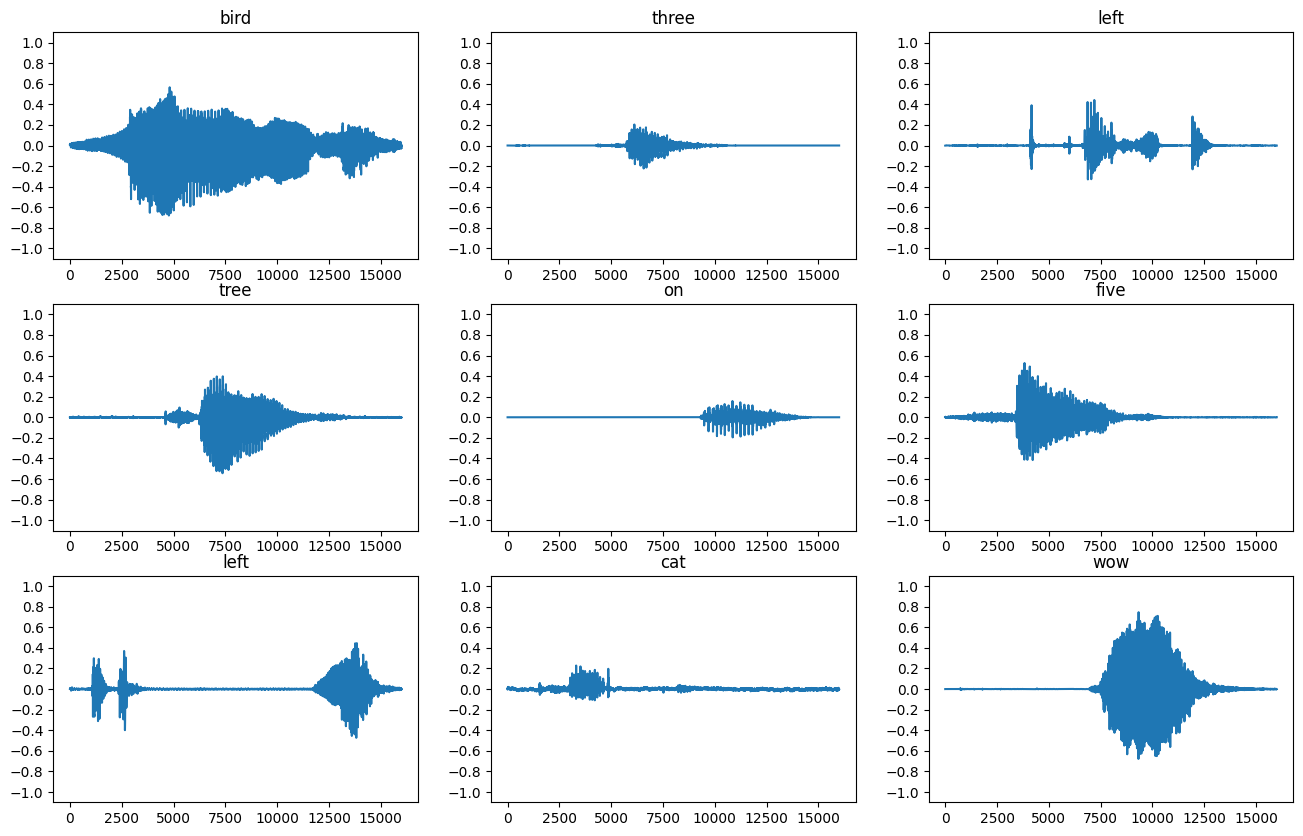

In [13]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

# Spectrogram

In [14]:
# frame_lenght (windows) = 0.025 * 16000 = 400 -> 512
# frame_step (hop) = 0.010 * 16000 = 160 -> 128

def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=400, frame_step=160)
    
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
    

# Mel spectogram

In [15]:
def get_mel_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    sample_rate = 16000
    frame_length = 400
    stft  = tf.signal.stft(waveform, frame_length=frame_length, frame_step=160)
    
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(stft)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    #spectrogram = spectrogram[..., tf.newaxis]
    
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stft.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0, 8000, 40
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix( 
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
        upper_edge_hertz)
    
    mel_spectrogram = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
    
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))
    
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    
    return mel_spectrogram

# MCCF

In [16]:
def get_mfcc_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    sample_rate = 16000
    frame_length = 400
    stft  = tf.signal.stft(waveform, frame_length=frame_length, frame_step=160)
    
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(stft)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    #spectrogram = spectrogram[..., tf.newaxis]
    
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stft.shape[-1]
    
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0, 8000, 40
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix( 
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
        upper_edge_hertz)
    
    mel_spectrogram = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
    
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))
        
    #Part per fer mfcc
    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrogram)[..., :13]
    
    mfcc = mfcc[..., tf.newaxis]

    return mfcc

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [17]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    mel_spectrogram = get_mel_spectrogram(waveform)
    mfcc_spectrogram = get_mfcc_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (98, 257, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (98, 257, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (98, 257, 1)
Audio playback


Now, define a function for displaying a spectrogram:

# Funció per plotejar MelSpectogram i Spectrogram, per el MCCF no cal fer el log

In [18]:
def plot_spectrogram(spectrogram, ax): 
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

In [19]:
def plot_mfcc_spectrogram(spectrogram, ax): 
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, spectrogram)

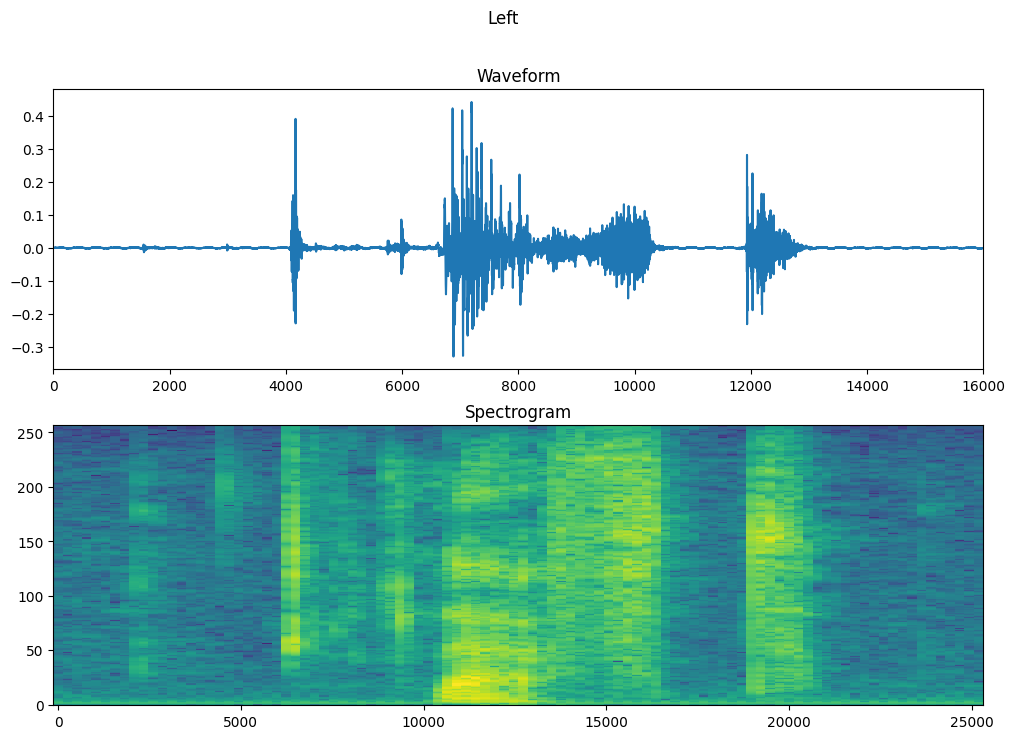

In [20]:
# Normal Spectrogram
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

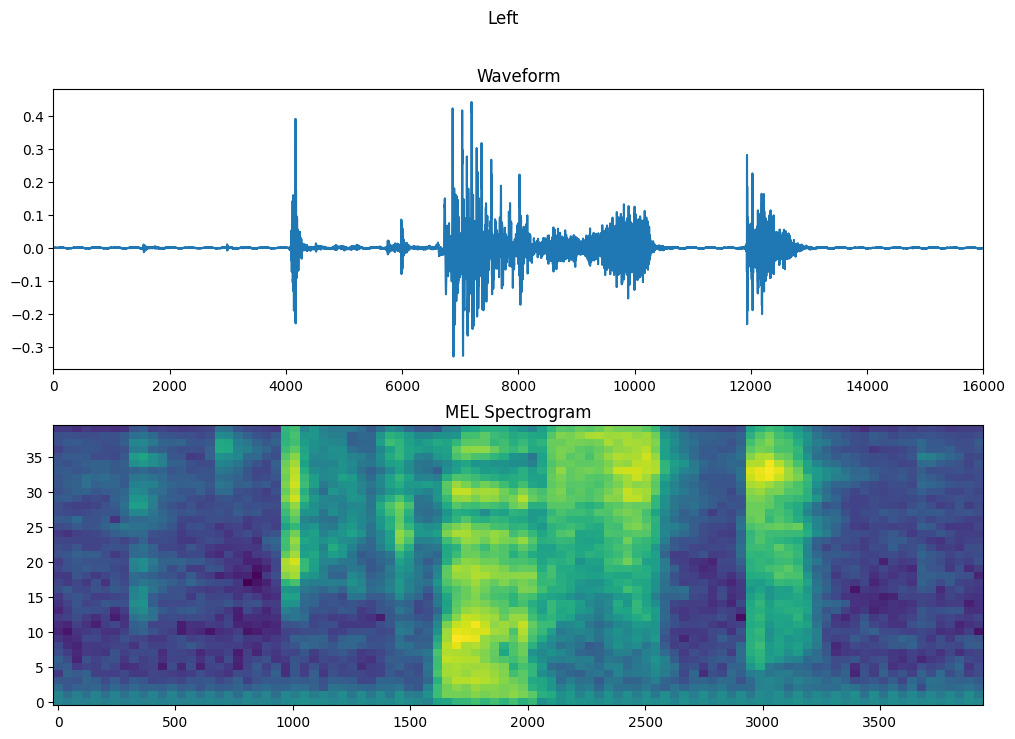

In [21]:
# Mel Spectrogram
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(mel_spectrogram, axes[1])
axes[1].set_title('MEL Spectrogram')
plt.suptitle(label.title())
plt.show()

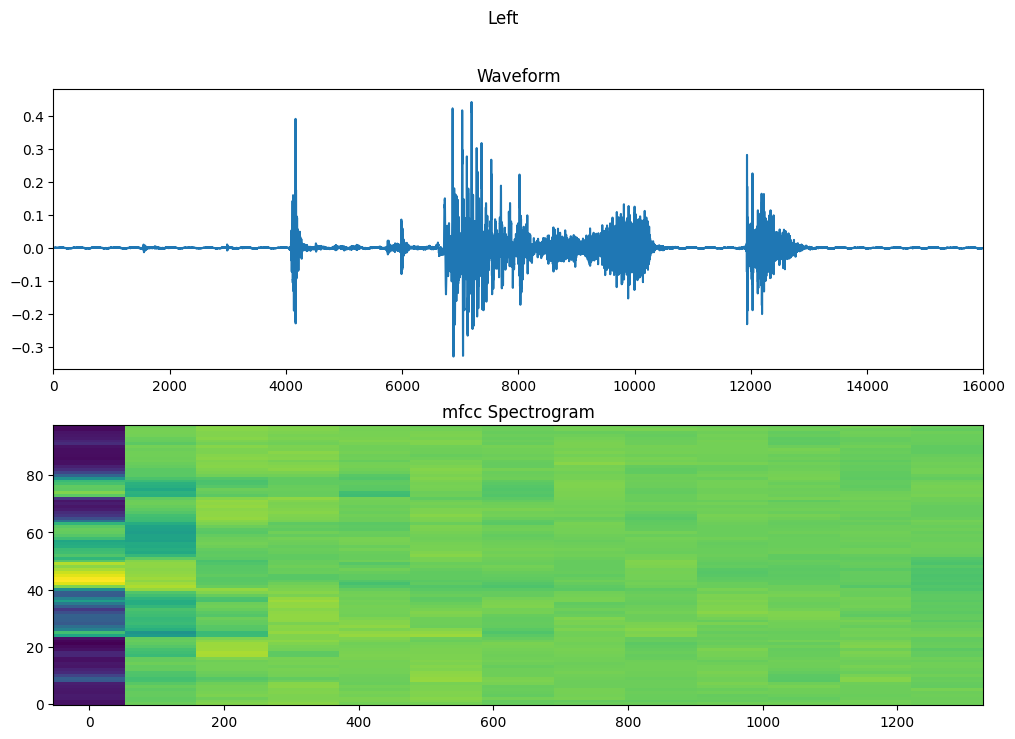

In [22]:
# mfcc Spectrogram
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_mfcc_spectrogram(mfcc_spectrogram, axes[1])
axes[1].set_title('mfcc Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [23]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [25]:
def make_mel_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_mel_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_mel_spectrogram_ds = make_mel_spec_ds(train_ds)
val_mel_spectrogram_ds = make_mel_spec_ds(val_ds)
test_mel_spectrogram_ds = make_mel_spec_ds(test_ds)

In [27]:
def make_mfcc_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_mfcc_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_mfcc_spectrogram_ds = make_mfcc_spec_ds(train_ds)
val_mfcc_spectrogram_ds = make_mfcc_spec_ds(val_ds)
test_mfcc_spectrogram_ds = make_mfcc_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
for example_mel_spectrograms, example_mel_spect_labels in train_mel_spectrogram_ds.take(1):
  break
for example_mfcc_spectrograms, example_mfcc_spect_labels in train_mfcc_spectrogram_ds.take(1):
  break

In [30]:
rows = 3
cols = 3
n = rows*cols

**NORMALS**

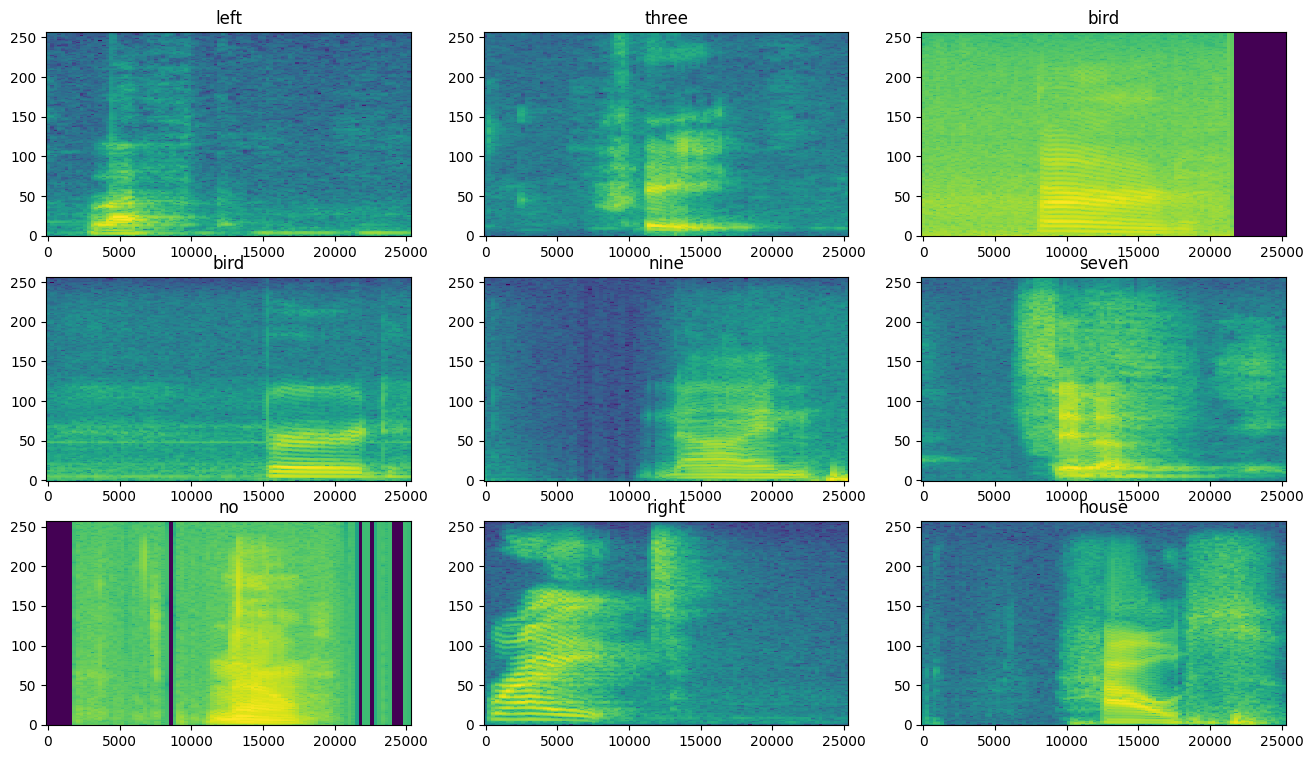

In [31]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

**MEL**

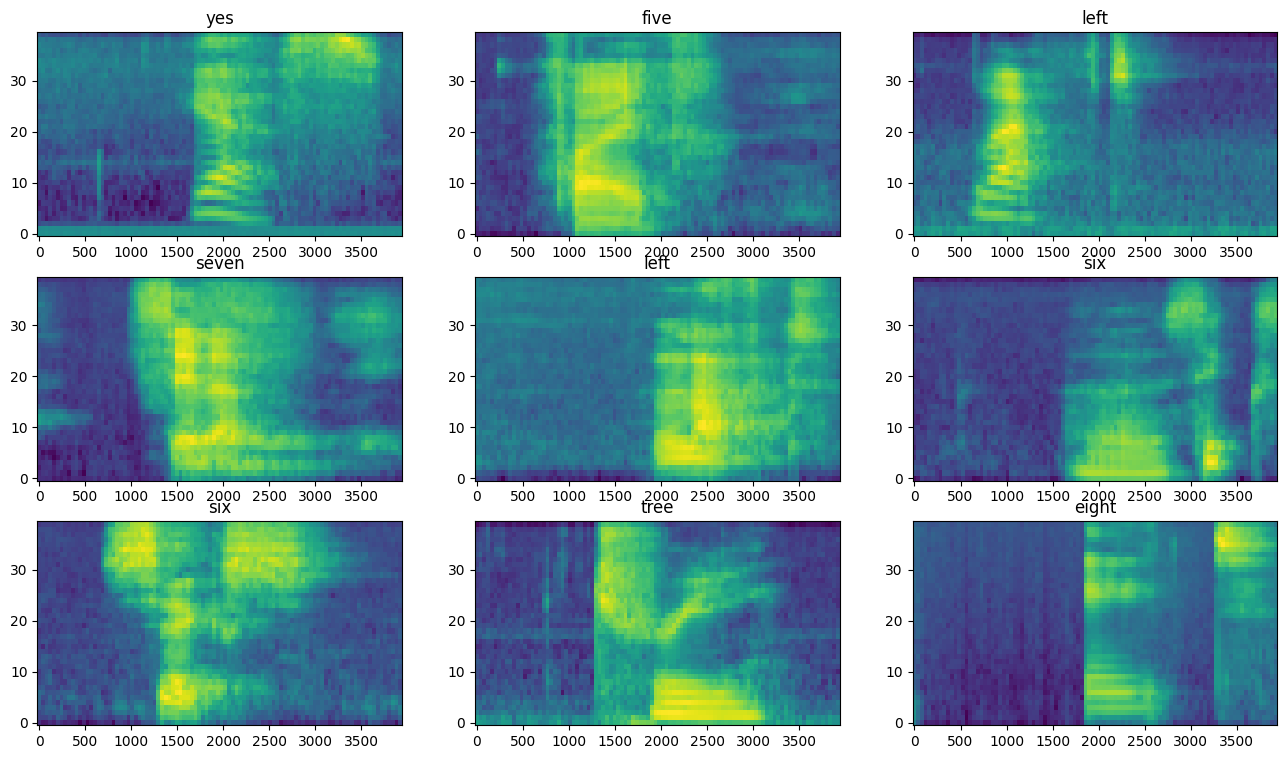

In [32]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_mel_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_mel_spect_labels[i].numpy()])

plt.show()

**MFCC**

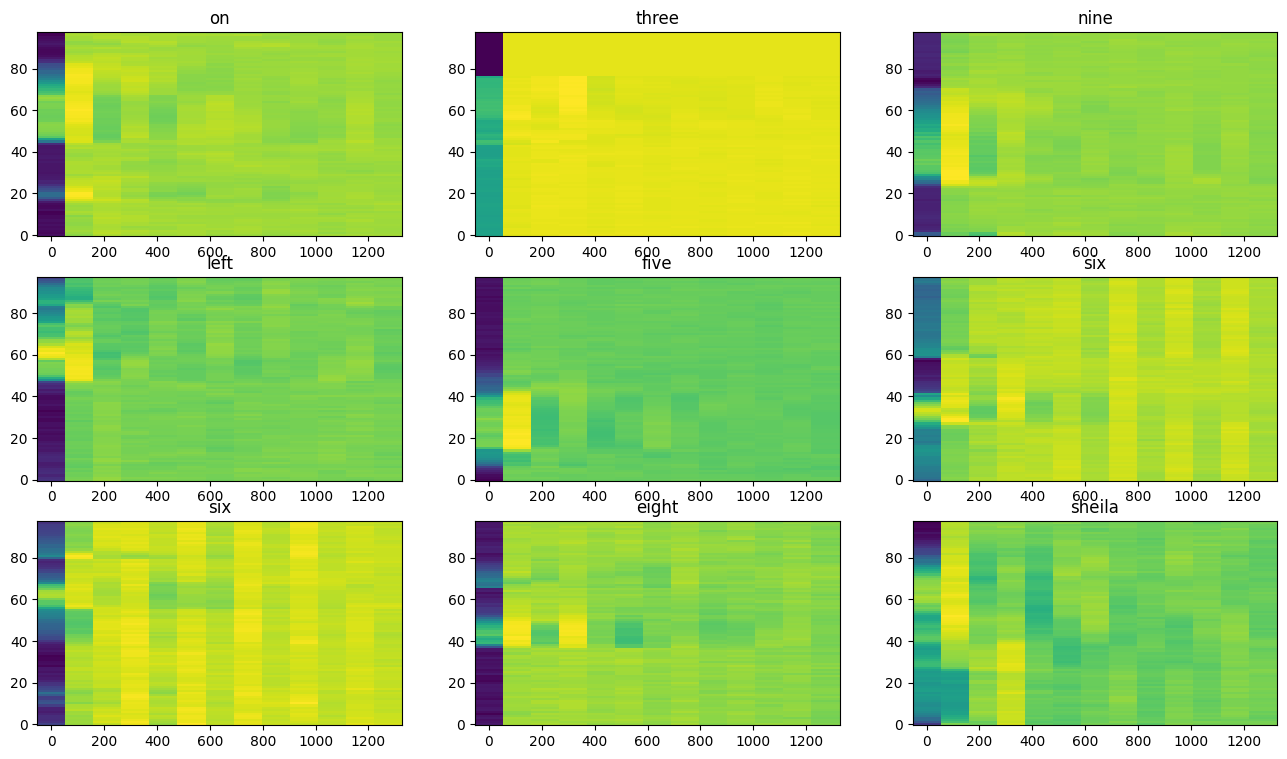

In [33]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_mfcc_spectrogram(example_mfcc_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_mfcc_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [34]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [35]:
train_mel_spectrogram_ds = train_mel_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mel_spectrogram_ds = val_mel_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mel_spectrogram_ds = test_mel_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [36]:
train_mfcc_spectrogram_ds = train_mfcc_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfcc_spectrogram_ds = val_mfcc_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mfcc_spectrogram_ds = test_mfcc_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [37]:
# We provide some function you may find useful for your models

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Treure capa embeddings
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [38]:
# Espectrograma mel

input_shape = example_mel_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization() # no tocar 
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_mel_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_mel = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels),
])

model_mel.summary()

Input shape: (98, 40, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (N

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [39]:
model_mel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


Train the model over 10 epochs for demonstration purposes:

In [40]:
# Entrenem 
EPOCHS = 20
history = model_mel.fit(
    train_mel_spectrogram_ds,
    validation_data=val_mel_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
810/810 [==============================] - 30s 36ms/step - loss: 2.2588 - accuracy: 0.3765 - val_loss: 1.7600 - val_accuracy: 0.5164
Epoch 2/20
810/810 [==============================] - 14s 18ms/step - loss: 1.5148 - accuracy: 0.5834 - val_loss: 1.3741 - val_accuracy: 0.6213
Epoch 3/20
810/810 [==============================] - 15s 18ms/step - loss: 1.2100 - accuracy: 0.6673 - val_loss: 1.2168 - val_accuracy: 0.6604
Epoch 4/20
810/810 [==============================] - 15s 18ms/step - loss: 1.0213 - accuracy: 0.7157 - val_loss: 1.0822 - val_accuracy: 0.7076
Epoch 5/20
810/810 [==============================] - 14s 18ms/step - loss: 0.8965 - accuracy: 0.7502 - val_loss: 0.9952 - val_accuracy: 0.7355
Epoch 6/20
810/810 [==============================] - 15s 18ms/step - loss: 0.7996 - accuracy: 0.7764 - val_loss: 0.9571 - val_accuracy: 0.7441
Epoch 7/20
810/810 [==============================] - 15s 18ms/step - loss: 0.7285 - accuracy: 0.7957 - val_loss: 0.9440 - val_accuracy:

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

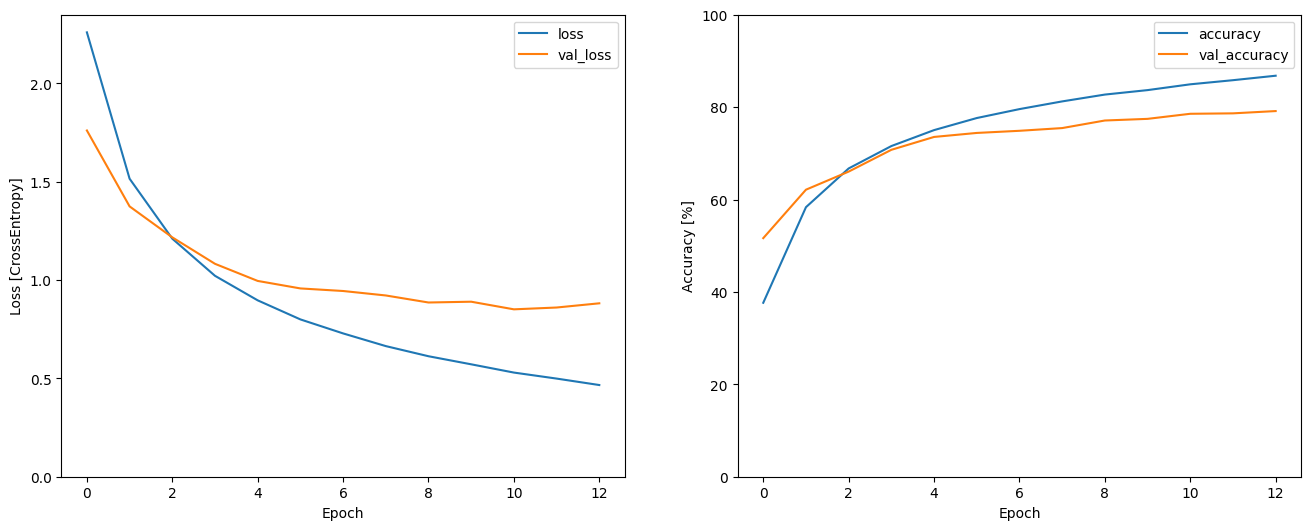

In [41]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [42]:
model_mel.evaluate(test_mel_spectrogram_ds, return_dict=True)

102/102 [==============================] - 6s 56ms/step - loss: 0.8620 - accuracy: 0.7959


{'loss': 0.8619560599327087, 'accuracy': 0.7958648204803467}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [43]:
y_pred = model_mel.predict(test_mel_spectrogram_ds)

102/102 [==============================] - 1s 7ms/step


In [44]:
y_pred = tf.argmax(y_pred, axis=1)

In [45]:
y_true = tf.concat(list(test_mel_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

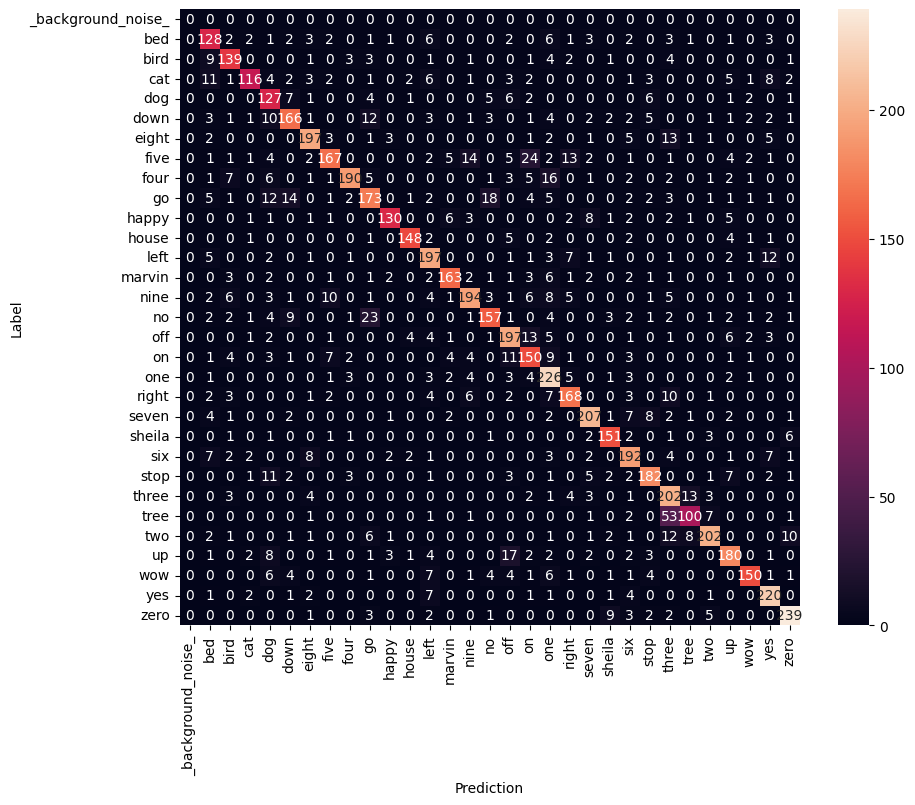

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Generate the submission file

The code below produces the `submission.csv` file, which you are required to submit for the competition. **Please do not make any changes in this cell**. 

In [47]:
import pandas as pd

l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission.csv', index=False)